In [1]:
cd ~/Desktop/DeepLearningPilot/

/Users/jz-rolling/Desktop/DeepLearningPilot


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize,rescale
from skimage import measure, segmentation,morphology,filters,feature,exposure
import tifffile
import momia2 as mo
from momia2.classify.unet import *
import timeit
import pickle as pk
from tensorflow import keras
from unet import *
import glob, os
import seaborn as sns

In [3]:
model = tf.keras.models.load_model('/Users/jz-rolling/Desktop/DeepLearningPilot/AttResUnet_20221229_2channel_512/')

2023-01-03 15:32:18.492798: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 15:32:19.143779: E tensorflow/core/framework/node_def_util.cc:629] NodeDef mentions attribute validate_shape which is not in the op definition: Op<name=AssignVariableOp; signature=resource:resource, value:dtype -> ; attr=dtype:type; is_stateful=true> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node AssignNewValue}}


In [42]:
def patch2imagej_rois(patch,roifile_name,tolerance=0.2):
    from skimage.measure import approximate_polygon
    from roifile import ImagejRoi,ROI_TYPE,ROI_OPTIONS,roiwrite
    rois=[]
    for i,(x1,y1,contour) in enumerate(patch.regionprops[['$opt-x1','$opt-y1','$refined_contours']].values):
        c = contour[0]
        c = c+np.array([x1,y1])[np.newaxis,:]
        c = approximate_polygon(c,tolerance=tolerance)
        roi = ImagejRoi.frompoints(np.flip(c,axis=1))
        roi.roitype = ROI_TYPE.POLYGON
        roi.name = str(i)
        rois.append(roi)
    roiwrite(roifile_name,rois)

In [45]:
for f in sorted(glob.glob('/Users/jz-rolling/Desktop/DeepLearningPilot/Myco_image_lib/timelapse_revised/Msm_1.tif')):
    out_name = f.split('.tif')[0]+'_rois.zip'
    if not os.path.isfile(out_name):
        img = plt.imread(f)
        h,w = img.shape
        pred = mo.classify.classifier_helper.image2predict(normalize_image(img,mask=True),
                                                           model,size=512,channels=2)
        dist,mask = pred[0][:,:,0][:h,:w],pred[0][:,:,1][:h,:w]
        labeled_mask = mo.classify.classifier_helper.dist2labels_simp(dist,mask,
                                                                    dist_threshold=0.2,
                                                                    mask_threshold=0.8,
                                                                    opening=2,
                                                                    min_particle_size=50,
                                                                    watershedline=True)
        p=mo.Patch()
        p.load_data(0,{'C1':img},
                     ref_channel='C1')
        p.labeled_mask=labeled_mask
        p.locate_particles(precompute_contours=True,
                           contour_kwargs={'level':0.12,'dilation':False})
        p.refine_contours(smooth_factor=3,smoothing='moving_window',approximate=False,
                          step_range=(-2.5,2.5),tol=0.1)
        patch2imagej_rois(p,out_name,tolerance=0.4)
        break

In [15]:
img = v['Phase_Ian']
                pred = mo.classify.classifier_helper.image2predict(normalize_image(img,mask=True),model,size=512,channels=2)
                dist,mask = pred[0][:,:,0],pred[0][:,:,1]
                labeled_mask = dist2labels_simp(dist,mask,
                                                dist_threshold=0.25,
                                                mask_threshold=0.8,
                                                opening=2,
                                                min_particle_size=150,
                                                watershedline=True)
                p=mo.Patch()
                p.load_data(0,{'FITC':v['FITC_CLD'],'Phase_Ian':v['Phase_Ian']},
                             ref_channel='Phase_Ian')
                p.labeled_mask=labeled_mask
                p.locate_particles(precompute_contours=True,
                                   contour_kwargs={'level':0.12,'dilation':False})
                p.refine_contours(smooth_factor=3,smoothing='moving_window',approximate=False,
                                  step_range=(-2.5,2.5),tol=0.1)
                p.extract_midlines()

<ImagejRoi '62eb3648-8b86-11ed-9e0f-acde48001122'>

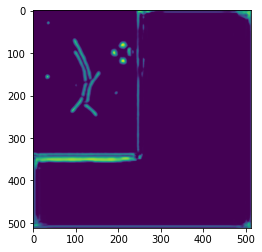

In [33]:
plt.imshow(pred[0][:,:,0])

In [8]:
from roifile import ImagejRoi, ROI_OPTIONS, ROI_TYPE, ROI_SUBTYPE